# Exploring the Allen Cell Types Database

In this notebook, we'll explore data from the [allen cell types database](http://celltypes.brain-map.org/). These databases include electrophysiological, morphological, and transcriptomic data from both mouse and humans!

To interact with these data, the allen institute provides an [SDK](http://alleninstitute.github.io/AllenSDK/cell_types.html). This notebook loosely follows some of the code samples [here](http://alleninstitute.github.io/AllenSDK/_static/examples/nb/cell_types.html).

In [122]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

1) Get the cells!

In [4]:
from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.api.queries.cell_types_api import CellTypesApi
from allensdk.core.cell_types_cache import ReporterStatus as RS

# Instantiate the CellTypesCache instance.  The manifest_file argument
# tells it where to store the manifest, which is a JSON file that tracks
# file paths.  If you supply a relative path (like this), it will go
# into your current working directory
ctc = CellTypesCache(manifest_file='cell_types/manifest.json')

# get all the cells
cells = ctc.get_cells()

2) Preprocess cells

In [35]:
filter_frame = lambda frame, str : frame.drop(list(frame.filter(regex = str)), axis = 1)
# get ephys features for recorded cells
ephys_features = ctc.get_ephys_features(dataframe=True)
ef_df = ephys_features.drop(['has_delay'], axis=1)
ef_df.set_index('specimen_id', inplace=True)
ef_df = filter_frame(ef_df, 'id')
ef_df.head()
# get morphology features for reconstructed cells
morphology_features = ctc.get_morphology_features(dataframe=True)
mf_df = morphology_features.drop(
    ['average_bifurcation_angle_remote', 'hausdorff_dimension'], axis=1)
mf_df = filter_frame(mf_df, 'scale_factor')
mf_df.set_index('specimen_id', inplace=True)
mf_df = filter_frame(mf_df, 'id')
# or download both morphology and ephys features at the same time
# all_features = ctc.get_all_features(dataframe=True, require_reconstruction=True)

/usr/local/lib/python2.7/site-packages/allensdk/core/cell_types_cache.py:154: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  features_df = pd.DataFrame.from_csv(file_name)
/usr/local/lib/python2.7/site-packages/allensdk/core/cell_types_cache.py:188: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  features_df = pd.DataFrame.from_csv(file_name)


3) Extract general properties that we might want to try to predict for each cell

In [131]:
# find matches
# ids = [c['id'] for c in cells]
cell_index = { c['id']: c for c in cells }
ids = cell_index.keys()
in_both = list(set(ids).intersection(set(ef_df.index)))
# get info about each cell
cell_type = list()
for cid in in_both:
    this_cell = cell_index[cid]
    this_donor = this_cell['donor']
    cell_type.append((this_cell['dendrite_type'],
                     this_cell['structure']['acronym'],
                     this_donor['sex_full_name'],
                     this_donor['age_id'],
                     this_cell['transgenic_line']))
# convert to dataframe
ct_df = pd.DataFrame(columns=['spines','structure', 'sex', 'age_id', 'transgenic_line'],
                     data=cell_type, index=in_both)
ct_df.head()

,spines,structure,sex,age_id,transgenic_line
480116737,spiny,VISp5,Male,20,Rorb-IRES2-Cre
318543876,aspiny,VISp4,Male,298414240,Pvalb-IRES-Cre
471767045,spiny,VISp5,Male,298414240,Rbp4-Cre_KL100
485287944,spiny,VISp6a,Female,97,Ntsr1-Cre_GN220
481099785,aspiny,VISp4,Male,20,Htr3a-Cre_NO152


In [132]:
# make sure both have same index
X = ef_df.loc[in_both, :]
Y = ct_df.loc[in_both,:]
threshold = 50
vc = Y.structure.value_counts()
structures_to_keep = vc[vc >= threshold].index.values
to_keep = Y['structure'].isin(structures_to_keep)
Y = Y.loc[to_keep, :]
X = X.loc[to_keep, :]

4) Examine the electrophysiological features 

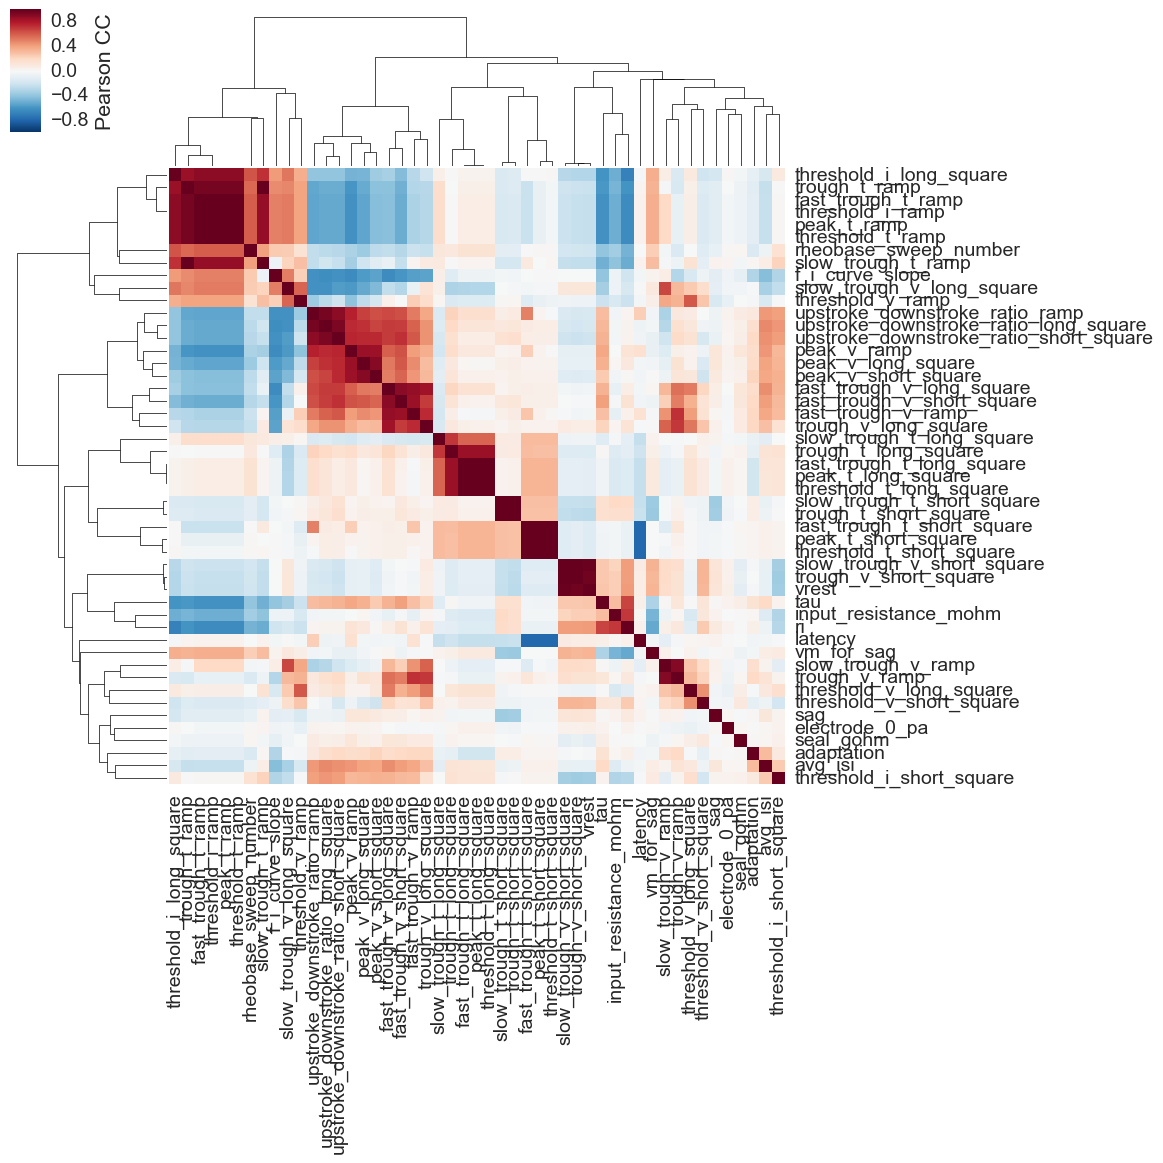

In [134]:
g = sns.clustermap(X.corr(), cbar_kws={'label': 'Pearson CC'})
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0);

In [40]:
# remove cells with lots of NaNs
bad_cells = pd.isna(X[['fast_trough_t_ramp',
                       'electrode_0_pa',
                       'slow_trough_t_short_square']]).any(axis=1)
Y = Y.loc[~bad_cells]
X = X.loc[~bad_cells, :]
# remove categories with lots of NaNs
X.drop(X.columns[np.sum(pd.isna(X)) > 50], axis=1, inplace=True)

In [41]:
from sklearn.preprocessing import RobustScaler
X = RobustScaler().fit_transform(X)

In [42]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
skf = StratifiedKFold(n_splits=5)
model = RidgeClassifier()

scores = cross_val_score(model, X, Y.spines, cv=skf)

In [43]:
scores

array([ 0.94350282,  0.96610169,  0.94886364,  0.94827586,  0.96551724])

In [120]:
network_pal = sns.color_palette("Set2", 2)
mf_and_ef = pd.concat([ef_df.add_prefix("ef."), mf_df.add_prefix("mf.")], axis=1, join="inner")
corrmat = mf_and_ef.corr()
cls = list()
for clm in corrmat.columns:
    if clm.split(".")[0] == "ef":
        cls.append(network_pal[0])
    else:
        cls.append(network_pal[1])

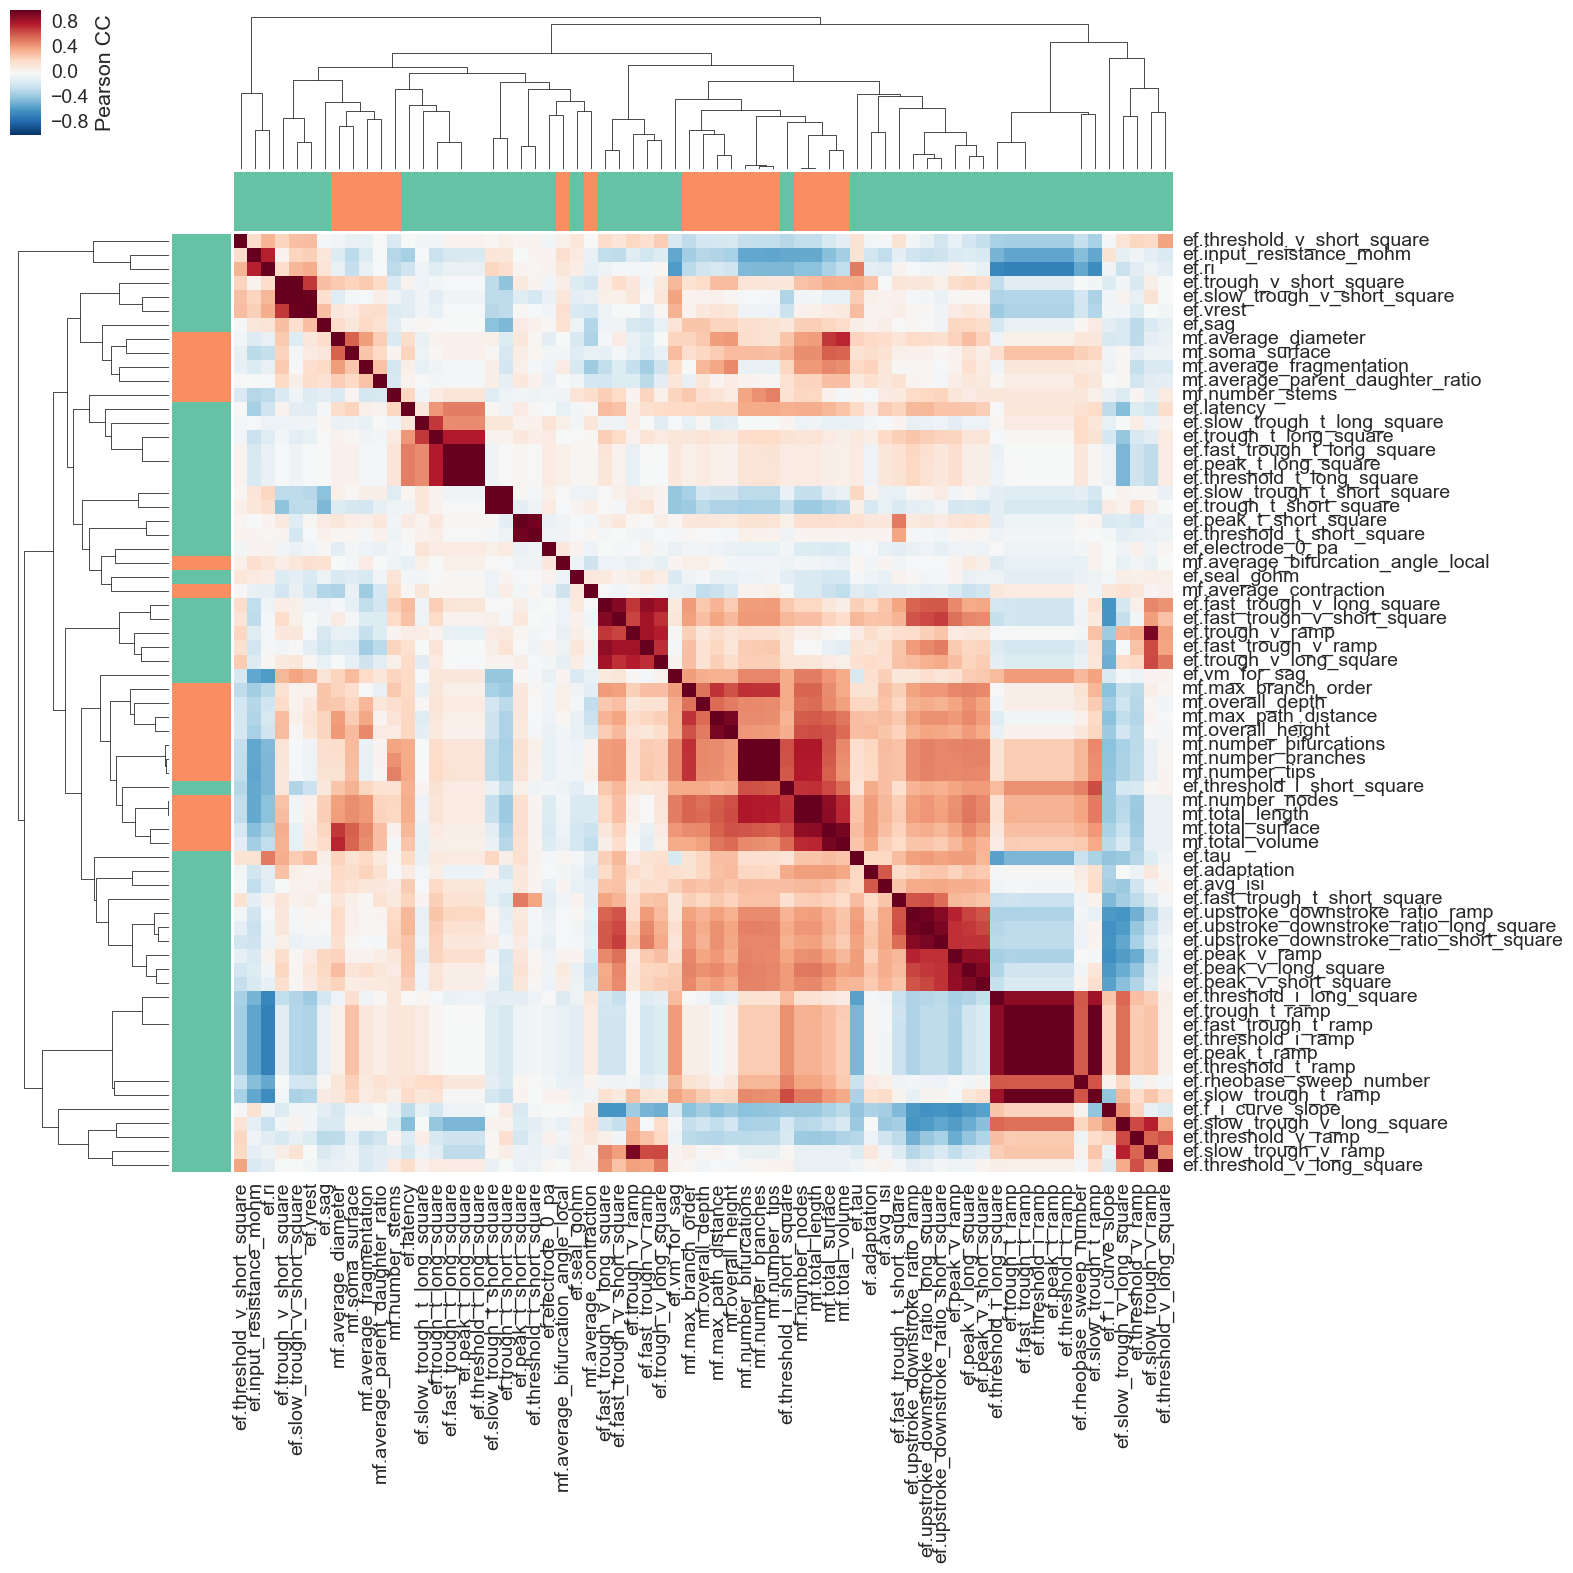

In [130]:
sns.set(font_scale=1.4)
g = sns.clustermap(corrmat, row_colors=cls, col_colors=cls,
                   cbar_kws={'label': 'Pearson CC'}, figsize=(15,15))
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0);

In [44]:
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y.spines,
                                                    train_size=0.75, test_size=0.25)

/Users/davidhbrann/anaconda3/envs/allen/lib/python2.7/site-packages/deap/tools/_hypervolume/pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


In [47]:
tpot = TPOTClassifier(verbosity=2, max_time_mins=10)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

/Users/davidhbrann/anaconda3/envs/allen/lib/python2.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/davidhbrann/anaconda3/envs/allen/lib/python2.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
Optimization Progress: 100%|██████████| 200/200 [04:46<00:00,  8.63s/pipeline]

Generation 1 - Current best internal CV score: 0.945417586297


Optimization Progress: 100%|██████████| 300/300 [08:02<00:00,  2.56pipeline/s]

Generation 2 - Current best internal CV score: 0.945417586297



10.4882549333 minutes have elapsed. TPOT will close down.
TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: LinearSVC(input_matrix, C=1.0, dual=True, loss=hinge, penalty=l2, tol=0.1)


ValueError: could not convert string to float: aspiny

In [48]:
tpot.fitted_pipeline_

Pipeline(memory=None,
     steps=[('linearsvc', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.1, verbose=0))])

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MaxAbsScaler
model = RandomForestClassifier(bootstrap=True, criterion='entropy',
                               max_features=0.8, min_samples_leaf=11,
                               min_samples_split=12, n_estimators=100)
# only evaluate spiny
scores = cross_val_score(model, X[np.where(Y.spines=='spiny')[0], :], Y.loc[Y.spines=='spiny', 'structure'], cv=skf)
print(scores)
scores.mean()

[ 0.6039604   0.61386139  0.6969697   0.57575758  0.56122449]


0.61035470894028176

0.59031025551534744